In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [2]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
from itertools import chain
import random
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Add
from tensorflow.keras.metrics import MeanIoU

2025-10-01 12:36:06.850655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759322167.018612      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759322167.075061      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def iou_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

miou_metric = MeanIoU(num_classes=2, name="mean_iou")


I0000 00:00:1759322179.069425      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
patient = []
for d in os.listdir('../input/lgg-mri-segmentation/kaggle_3m/'):
    if d != 'data.csv' and d != 'README.md':
        patient.append(d)
print(f"{len(patient)} patients uploaded! ")

110 patients uploaded! 


In [5]:
def create_dataset(start, end, dataset_type):
    train_files = []
    mask_files = []
    c = 0
    
    for i, p in enumerate(patient[start:end]):
        vals = []
        patient_masks = glob(f'../input/lgg-mri-segmentation/kaggle_3m/{p}/*_mask*')
        mask_files.append(patient_masks)
        
        for m in patient_masks:
            vals.append(np.max(cv2.imread(m)))
            
        if max(vals) == 0:
            print(f' patient {p} has no tumor ')
            c += 1
    if c == 0:
        print(f'All patients in {dataset_type} have brain tumor')
        
    mask_files = list(chain.from_iterable(mask_files))
    
    for m in mask_files:
        train_files.append(m.replace('_mask', ''))
        
    df = pd.DataFrame(data={"filepath": train_files, 'mask': mask_files})
    return df

In [6]:
a = int(0.9 * len(patient))
b = int(0.8 * a)

df_train = create_dataset(0, b, 'training')
df_val = create_dataset(b, a, 'validation')
df_test = create_dataset(a, len(patient), 'testing')

print(f"Training group: {len(df_train)}")
print(f"Validation group: {len(df_val)}")
print(f"Testing group: {len(df_test)}")

All patients in training have brain tumor
All patients in validation have brain tumor
All patients in testing have brain tumor
Training group: 2818
Validation group: 752
Testing group: 359


Pixels 965
[[     0 184875]
 [   255  11733]]
Display Training Samples :


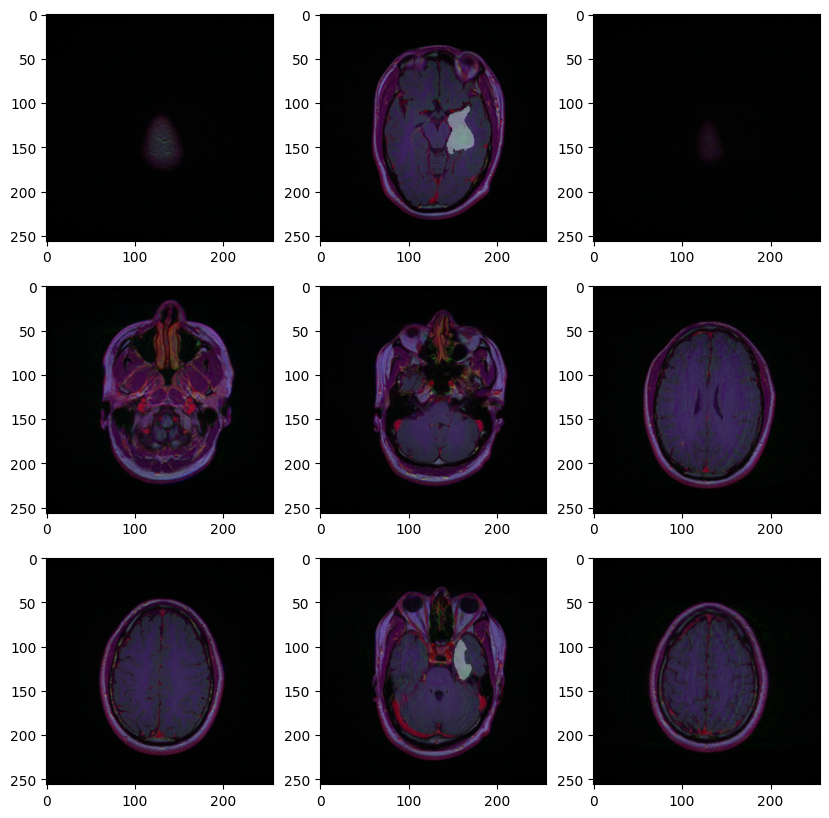

In [7]:
def pixel_value_counts(col, end):
    p = np.random.randint(0, end)
    img = cv2.imread(df_train[col].loc[p])
    unique, counts = np.unique(img, return_counts=True)
    print(f'Pixels {p}')
    print(np.asarray((unique, counts)).T)

pixel_value_counts('mask', len(df_train))

for i in range(len(df_test)):
    arr = np.where(cv2.imread(df_test['mask'].loc[i]) == 255, 1, 0) 
    v = np.max(arr)
    df_test.loc[i, 'res'] = v

print("Display Training Samples :")
df_train.sample(3, random_state=42)

f, ax = plt.subplots(3, 3, figsize=(10, 10))
ax = ax.flatten()
for j in range(9):
    i = 1453 + j
    img = cv2.imread(df_train['filepath'].loc[i])
    msk = cv2.imread(df_train['mask'].loc[i])
    ax[j].imshow(msk)
    ax[j].imshow(img, alpha=0.7)
plt.show()

In [8]:
def img_dataset(df_inp, path_img, path_mask, aug_args, batch_size):
    img_gen = ImageDataGenerator(rescale=1./255., **aug_args)
    
    df_img = img_gen.flow_from_dataframe(
        dataframe=df_inp,
        x_col=path_img,
        class_mode=None,
        batch_size=batch_size,
        color_mode='rgb',
        seed=1,
        target_size=(256, 256)
    )
    df_mask = img_gen.flow_from_dataframe(
        dataframe=df_inp,
        x_col=path_mask,
        class_mode=None,
        batch_size=batch_size,
        color_mode='grayscale',
        seed=1,
        target_size=(256, 256)
    )
    
    return df_img, df_mask

In [9]:
def dice_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersec = K.sum(y_true * y_pred)
    return (-((2 * intersec + 0.1) / (K.sum(y_true) + K.sum(y_pred) + 0.1)))

def iou(y_true, y_pred):
    intersec = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersec + 0.1) / (union - intersec + 0.1)
    return iou

In [10]:
def conv_block(inp, filters):
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(inp)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    return x

def encoder_block(inp, filters):
    x = conv_block(inp, filters)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def attention_block(l_layer, h_layer, attention_type='spatial'):
    if attention_type == 'global':
        channel_axis = 3
        h_shape = K.int_shape(h_layer)
        
        gap = GlobalAveragePooling2D()(h_layer)
        gap = Reshape((1, 1, h_shape[channel_axis]))(gap)
        
        channel_weights = Dense(h_shape[channel_axis] // 8, activation='relu')(gap)
        channel_weights = Dense(h_shape[channel_axis], activation='sigmoid')(channel_weights)
        
        channel_refined = Multiply()([h_layer, channel_weights])
        
        phi = Conv2D(h_shape[channel_axis], (1, 1), padding='same')(l_layer)
        theta = Conv2D(h_shape[channel_axis], (1, 1), strides=(2, 2), padding='same')(channel_refined)
        x = Add()([phi, theta])
        x = Activation('relu')(x)
        x = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)
        x = UpSampling2D(size=(2, 2))(x)
        x = Multiply()([channel_refined, x])
    else:
        phi = Conv2D(h_layer.shape[-1], (1, 1), padding='same')(l_layer)
        theta = Conv2D(h_layer.shape[-1], (1, 1), strides=(2, 2), padding='same')(h_layer)
        x = Add()([phi, theta])
        x = Activation('relu')(x)
        x = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)
        x = UpSampling2D(size=(2, 2))(x)
        x = Multiply()([h_layer, x])
    
    x = BatchNormalization(axis=3)(x)
    return x

def decoder_block(inp, filters, concat_layer, attention_type='spatial'):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inp)
    concat_layer = attention_block(inp, concat_layer, attention_type=attention_type)
    x = concatenate([x, concat_layer])
    x = conv_block(x, filters)
    return x

In [11]:
inputs = Input((256, 256, 3))
d1, p1 = encoder_block(inputs, 64)    
d2, p2 = encoder_block(p1, 128)        
d3, p3 = encoder_block(p2, 256)        
d4, p4 = encoder_block(p3, 512)        

b1 = conv_block(p4, 1024)              

e2 = decoder_block(b1, 512, d4, attention_type='global')  
e3 = decoder_block(e2, 256, d3, attention_type='global')  
e4 = decoder_block(e3, 128, d2, attention_type='spatial') 
e5 = decoder_block(e4, 64, d1, attention_type='spatial')  

outputs = Conv2D(1, (1, 1), activation="sigmoid")(e5)
model = Model(inputs=[inputs], outputs=[outputs], name='HybridAttentionUnet')

In [12]:
model.summary()

Model: "HybridAttentionUnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 32,177,509 (122.75 MB)

 Trainable params: 32,169,701 (122.72 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [13]:
augmentation_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)

In [14]:
batch_size = 16

image_datagen = ImageDataGenerator(rescale=1./255.)
mask_datagen = ImageDataGenerator(rescale=1./255.)

train_image_generator = image_datagen.flow_from_dataframe(
    df_train,
    x_col='filepath',
    class_mode=None,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='rgb',
    seed=1
)

train_mask_generator = mask_datagen.flow_from_dataframe(
    df_train,
    x_col='mask',
    class_mode=None,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='grayscale',
    seed=1
)

val_image_generator = image_datagen.flow_from_dataframe(
    df_val,
    x_col='filepath',
    class_mode=None,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='rgb',
    seed=1
)

val_mask_generator = mask_datagen.flow_from_dataframe(
    df_val,
    x_col='mask',
    class_mode=None,
    target_size=(256, 256),
    batch_size=batch_size,
    color_mode='grayscale',
    seed=1
)

Found 2818 validated image filenames.
Found 2818 validated image filenames.
Found 752 validated image filenames.
Found 752 validated image filenames.


In [15]:
def simple_generator(image_gen, mask_gen):
    while True:
        x = image_gen.__next__()
        y = mask_gen.__next__()
        y = (y > 0.5).astype(np.float32) 
        yield x, y

train_generator = simple_generator(train_image_generator, train_mask_generator)
val_generator = simple_generator(val_image_generator, val_mask_generator)

steps_per_epoch = len(df_train) // batch_size
validation_steps = len(df_val) // batch_size

In [16]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [17]:
model.compile(
    optimizer=Adam(1e-4),
    loss=dice_loss,
    metrics=["accuracy", dice_coef, iou_coef]
)

In [18]:
save_name = 'segmentation_unet.h5'
callbacks = [
    ModelCheckpoint(save_name, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)
]

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
I0000 00:00:1759322232.180620      58 service.cc:148] XLA service 0x7987440035e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759322232.181349      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759322234.337927      58 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-10-01 12:37:32.568598: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=3,k3=0} for conv (f32[16,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,128,128]{3,2,1,0}, f32[64,64,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_co

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8660 - dice_coef: 0.1003 - iou_coef: 0.0549 - loss: 0.8997
Epoch 1: val_loss improved from inf to 0.96725, saving model to segmentation_unet.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 158s 501ms/step - accuracy: 0.8664 - dice_coef: 0.1006 - iou_coef: 0.0550 - loss: 0.8994 - val_accuracy: 0.9872 - val_dice_coef: 0.0328 - val_iou_coef: 0.0167 - val_loss: 0.9672 - learning_rate: 1.0000e-04
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9890 - dice_coef: 0.2464 - iou_coef: 0.1455 - loss: 0.7516
Epoch 2: val_loss improved from 0.96725 to 0.82601, saving model to segmentation_unet.h5
176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 440ms/step - accuracy: 0.9890 - dice_coef: 0.2466 - iou_coef: 0.1456 - loss: 0.7514 - val_accuracy: 0.9700 - val_dice_coef: 0.1740 - val_iou_coef: 0.0968 - val_loss: 0.8260 - learning_rate: 1.0000e-04
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9925 - dice_coef: 0.3614 - iou_coef: 0.2285 - 

In [20]:
def create_test_generator(df, batch_size=32):
    image_datagen = ImageDataGenerator(rescale=1./255.)
    mask_datagen = ImageDataGenerator(rescale=1./255.)
    
    test_image_generator = image_datagen.flow_from_dataframe(
        df,
        x_col='filepath',
        class_mode=None,
        target_size=(256, 256),
        batch_size=batch_size,
        color_mode='rgb',
        shuffle=False,
        seed=42
    )
    
    test_mask_generator = mask_datagen.flow_from_dataframe(
        df,
        x_col='mask',
        class_mode=None,
        target_size=(256, 256),
        batch_size=batch_size,
        color_mode='grayscale',
        shuffle=False,
        seed=42
    )
    
    def test_generator():
        while True:
            x = test_image_generator.__next__()
            y = test_mask_generator.__next__()
            y = (y > 0.5).astype(np.float32)
            yield x, y
    
    return test_generator(), len(df) // batch_size

In [21]:
def eval_model(model_wts, custom_objects, seed=42): 
    model = load_model(model_wts, custom_objects=custom_objects)
    
    test_generator, test_steps = create_test_generator(df_test, batch_size=32)
 
    results = model.evaluate(test_generator, steps=test_steps, return_dict=True)
    
    print("Evaluation:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")
    

    np.random.seed(seed)
    tumor_indices = df_test[df_test['res'] == 1].index.tolist()
    
    if len(tumor_indices) == 0:
        print("No tumor samples in test set")
        return 
    
    indexes = np.random.choice(tumor_indices, min(5, len(tumor_indices)), replace=False)
    
    for i, idx in enumerate(indexes):
        img = cv2.imread(df_test.loc[idx, 'filepath'])
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        img = img[np.newaxis, :, :, :]
        
        pred = model.predict(img, verbose=0)
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(cv2.imread(df_test.loc[idx, 'filepath']), cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        true_mask = cv2.imread(df_test.loc[idx, 'mask'])[:, :, 0]
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        pred_mask = (np.squeeze(pred) > 0.5).astype(np.float32)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        true_mask_binary = (true_mask > 127).astype(np.float32)
        dice = dice_coef(true_mask_binary[np.newaxis, ..., np.newaxis], pred[np.newaxis, ...])
        print(f"Dice score for sample {i+1}: {dice:.4f}")


Found 359 validated image filenames.
Found 359 validated image filenames.
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - accuracy: 0.9970 - dice_coef: 0.7585 - iou_coef: 0.6387 - loss: 0.2415
Evaluation:
accuracy: 0.9960
dice_coef: 0.6737
iou_coef: 0.5593
loss: 0.3263


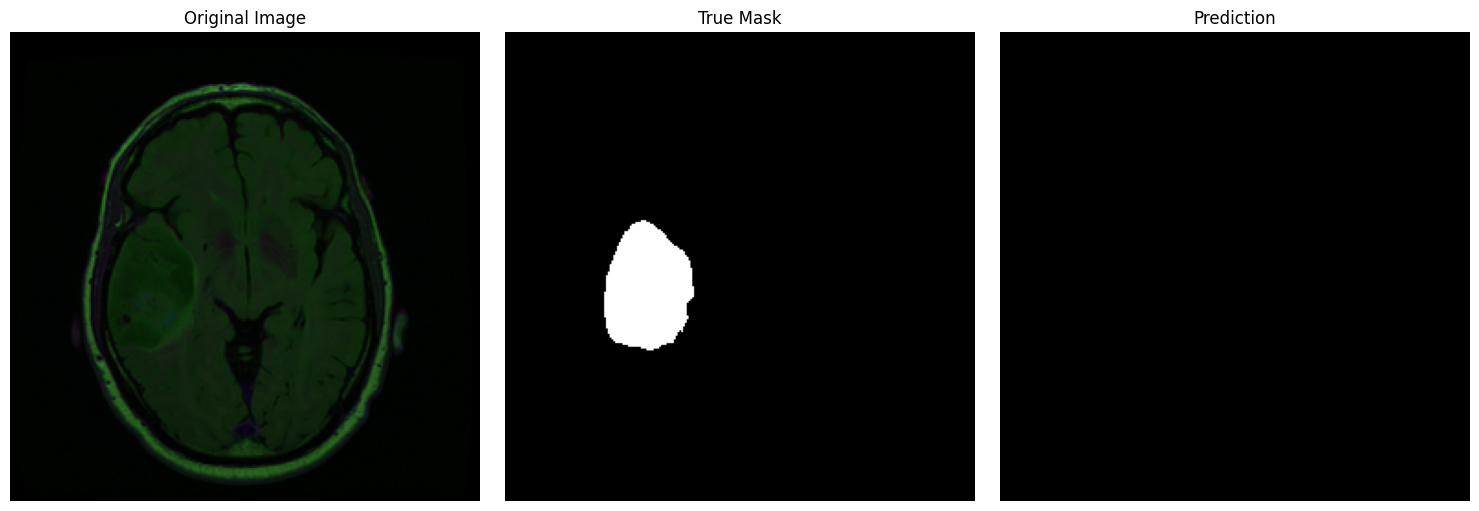

Dice score for sample 1: 0.0003


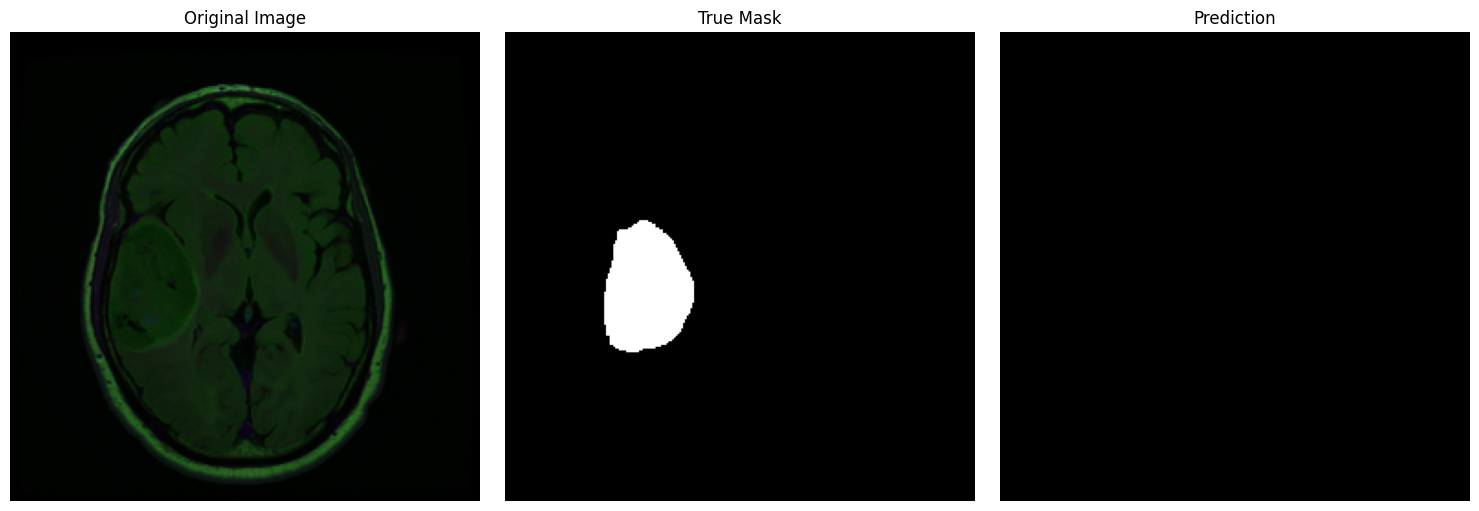

Dice score for sample 2: 0.0003


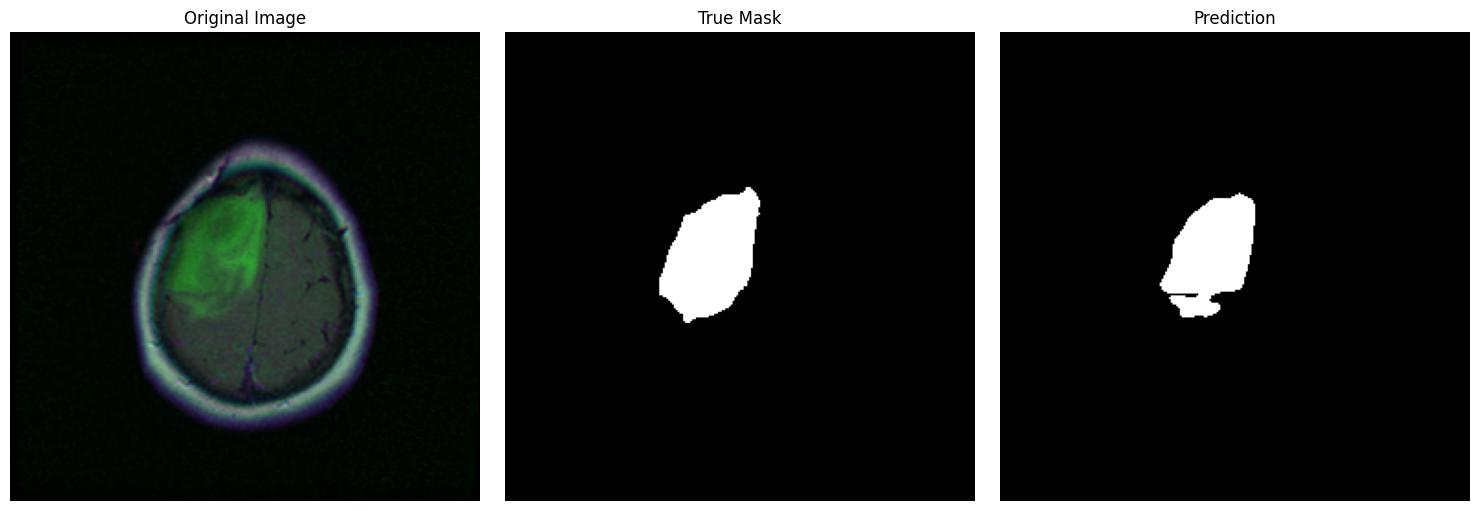

Dice score for sample 3: 0.8995


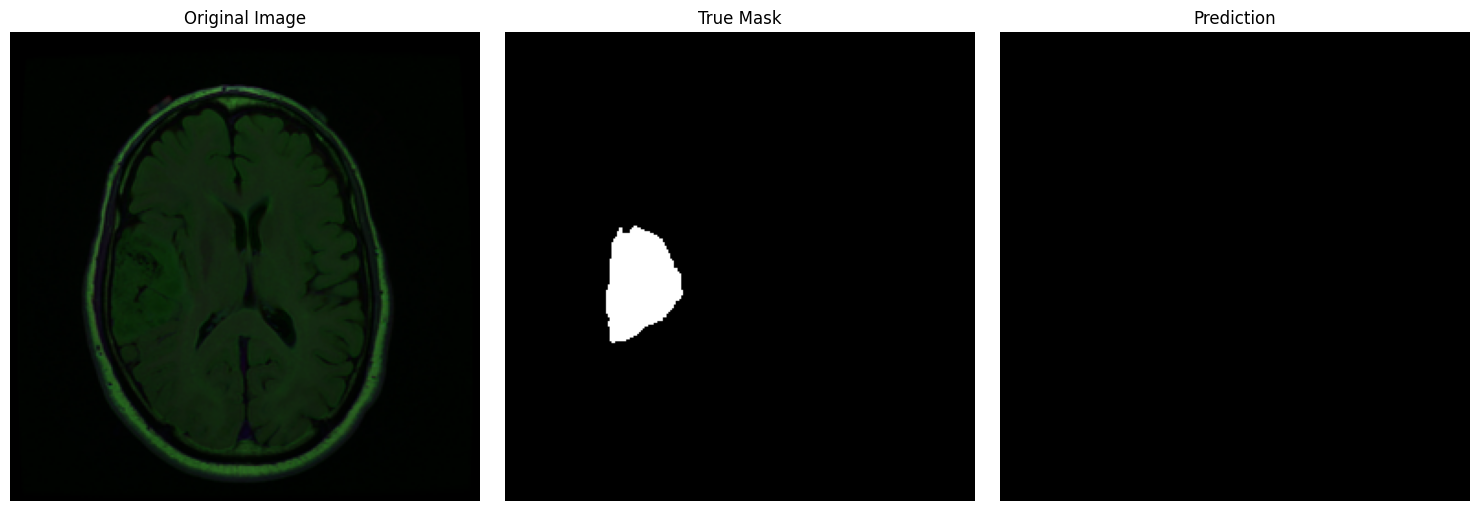

Dice score for sample 4: 0.0003


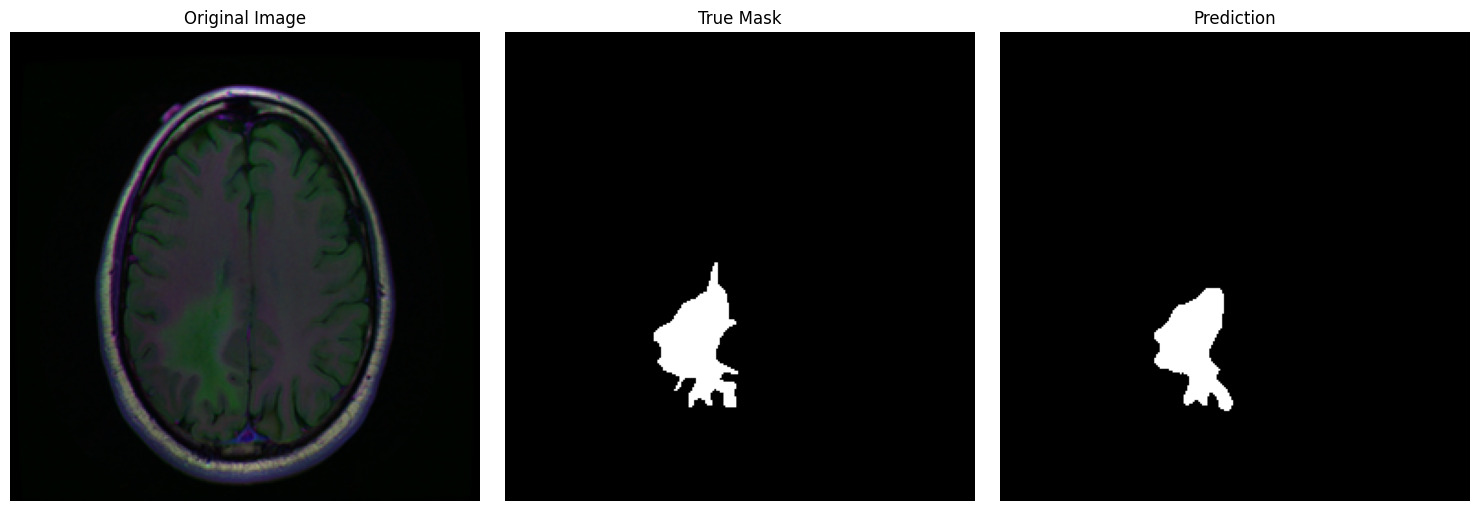

Dice score for sample 5: 0.9008


In [22]:
eval_model('segmentation_unet.h5', {
    'dice_loss': dice_loss,
    'iou': iou,
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score
}, seed=150)


In [23]:
model.save('segmentation_unet_final.h5')